In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



## Data Formatting <a name="data_formatting"/>


In [3]:
import pandas as pd

from urllib.request import urlopen
from zipfile import ZipFile
from io import BytesIO

#this zip is a bunch of zips for each station
zf = ZipFile("/content/drive/MyDrive/PRSA2017_Data_20130301-20170228.zip")

#make a dataframe and unpack all the zips into it
df = pd.DataFrame()
for file in zf.infolist():
    if file.filename.endswith('.csv'):
        df = df._append(pd.read_csv(zf.open(file)))

# the data format is broken into multiple columsn, so we need to fix that into a single DateTime
df['timestamp'] = pd.to_datetime(df[["year", "month", "day", "hour"]])
df.drop(columns=['No'], inplace=True)

#now turn both wind direction and station name into ints so we can treat them like categorical vars
df = df.replace(df['station'].unique(), list(range(len(df['station'].unique()))))
df = df.replace(df['wd'].unique(), list(range(len(df['wd'].unique()))))

df.head()

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,timestamp
0,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,0.0,4.4,0,2013-03-01 00:00:00
1,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,1.0,4.7,0,2013-03-01 01:00:00
2,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,0.0,5.6,0,2013-03-01 02:00:00
3,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,2.0,3.1,0,2013-03-01 03:00:00
4,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,1.0,2.0,0,2013-03-01 04:00:00


In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import time

def convert_to_timestamp(x):
    """Convert date objects to integers"""
    return time.mktime(x.timetuple())


def normalize(series):
    """Normalize the DF using min/max"""
    scaler = MinMaxScaler(feature_range=(-1, 1))
    dates_scaled = scaler.fit_transform(series)

    return dates_scaled

df['timestamp_ind'] = df['timestamp'].apply(convert_to_timestamp)
df['timestamp_ind'] = normalize(df[['timestamp_ind']])
pca_df = df.drop(['timestamp', 'year', 'month', 'day', 'hour'], axis='columns')
X = pca_df.values # getting all values as a matrix of dataframe
sc = StandardScaler() # creating a StandardScaler object
X_std = sc.fit_transform(X) # standardizing the data

pca_pm25 = PCA(n_components=5)
principalComponents_PM25 = pca_pm25.fit_transform(X_std)

pca_pm25.explained_variance_ratio_

array([0.27993098, 0.16634779, 0.10778534, 0.08644793, 0.07649932])

In [ ]:
pca_pm25 = PCA(n_components=0.95)
principalComponents_PM25 = pca_pm25.fit_transform(X_std)

pca_pm25.explained_variance_ratio_

array([0.27993098, 0.16634779, 0.10778534, 0.08644793, 0.07649932,
       0.07217492, 0.05948165, 0.03871491, 0.03341706, 0.02597669,
       0.02074129])

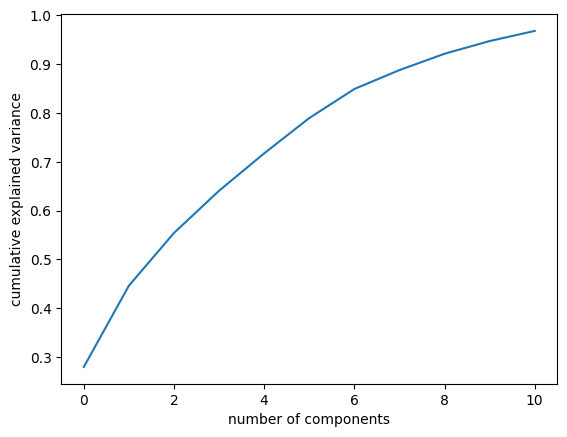

In [ ]:
plt.plot(np.cumsum(pca_pm25.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [ ]:
pd.DataFrame(pca_pm25.components_, columns = pca_df.columns)

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,timestamp_ind
0,0.419950,0.400414,0.337110,0.428611,0.430992,-0.244071,-0.243305,0.094684,-0.103090,-0.050311,-0.000974,-0.194102,0.035957,-0.018557
1,0.247370,0.248128,-0.008656,0.080670,0.094705,0.322625,0.510142,-0.301575,0.544958,0.148703,0.253063,-0.085257,0.020834,-0.124801
2,0.032918,0.056635,0.133969,-0.018992,0.066376,-0.011494,-0.187738,-0.540140,-0.241816,0.598892,0.012107,0.471398,-0.041622,0.067994
3,-0.043341,-0.108417,-0.366008,0.139395,0.027498,-0.436957,0.010785,-0.209201,0.283188,0.310759,-0.422888,-0.401445,0.025787,0.282811
4,-0.123258,-0.126997,0.253563,0.031549,-0.133827,-0.173433,0.006384,-0.112417,0.042874,0.110163,-0.242984,-0.166436,-0.194494,-0.839153
5,-0.108514,-0.107538,0.031010,0.064440,-0.056363,-0.112400,-0.030732,-0.026070,-0.017484,0.090291,0.194335,-0.043572,0.935781,-0.174075
6,-0.166964,-0.209359,0.027373,0.087247,-0.066672,-0.227372,-0.138200,-0.039560,-0.029424,0.172003,0.782690,-0.349955,-0.272738,0.056699
7,-0.001508,-0.092581,0.316681,-0.221925,0.078156,0.446654,-0.051659,0.385171,-0.046736,0.540570,-0.151953,-0.387813,0.044880,0.123903
8,0.218225,0.284427,-0.635406,-0.066165,-0.024592,-0.053345,-0.119701,0.421212,-0.055223,0.343314,0.133245,0.142251,-0.032870,-0.328905
9,-0.154160,-0.096315,0.286728,0.331914,-0.107851,-0.314601,0.345385,0.467993,0.244069,0.236698,0.002052,0.436602,-0.055811,0.127782


In [ ]:
initial_feature_names = pca_df.columns
# get the most important feature names
most_important = [np.abs(pca_pm25.components_[i]).argmax() for i in range(pca_pm25.n_components_)]
most_important_names = [initial_feature_names[most_important[i]] for i in range(pca_pm25.n_components_)]
print(most_important_names)

['CO', 'DEWP', 'RAIN', 'O3', 'timestamp_ind', 'station', 'wd', 'RAIN', 'SO2', 'PRES', 'CO']


In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression

y_s = df[['PM2.5']]
x_s = df[['TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM', 'wd', 'station', 'timestamp_ind']]

# configure to select all features
fs = SelectKBest(score_func=f_regression, k='all')

# learn relationship from training data
fs.fit(x_s, y_s)

results = pd.DataFrame({"column":x_s.columns, "score":fs.scores_})

print(results.sort_values(by=["score"], ascending=False))

#for i in range(len(fs.scores_)):
# print('Feature %d %s: %f' % (i, x_s.columns[i], fs.scores_[i]))

          column         score
4           WSPM  29596.179859
0           TEMP   7466.488882
2           DEWP   5251.510465
5             wd   3120.139781
6        station    428.761398
7  timestamp_ind    246.055690
3           RAIN     64.926256
1           PRES     17.824851


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression

y_s = df[df['station'] == 3][['PM2.5']]
x_s = df[df['station'] == 3][['TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM', 'wd', 'timestamp_ind']]

# configure to select all features
fs = SelectKBest(score_func=f_regression, k='all')

# learn relationship from training data
fs.fit(x_s, y_s)

results = pd.DataFrame({"column":x_s.columns, "score":fs.scores_})

print(results.sort_values(by=["score"], ascending=False))

#for i in range(len(fs.scores_)):
# print('Feature %d %s: %f' % (i, x_s.columns[i], fs.scores_[i]))

          column        score
4           WSPM  3218.934425
0           TEMP   744.236239
2           DEWP   502.256426
5             wd   330.414167
3           RAIN    12.062777
6  timestamp_ind     2.697578
1           PRES     0.008807


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
anova_df = df[['PM2.5', 'station']]
anova_df = anova_df.rename(columns={"PM2.5": "PM25"})

# get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Ordinary Least Squares (OLS) model
model = ols('PM25 ~ C(station)', data=anova_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(station),1.804090e+07,11.0,254.803782,0.0
Residual,2.708258e+09,420756.0,NaN,NaN


In [ ]:
!pip install fastdtw

# Computation packages
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 925.5 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512576 sha256=24d23c7c89a47f0fe0a87cb4de8a042967d8d258eacbbf52c59c3daecd4881b7
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d513c736bb93910277e1528ef4
Successfully built fastdtw


<Axes: >

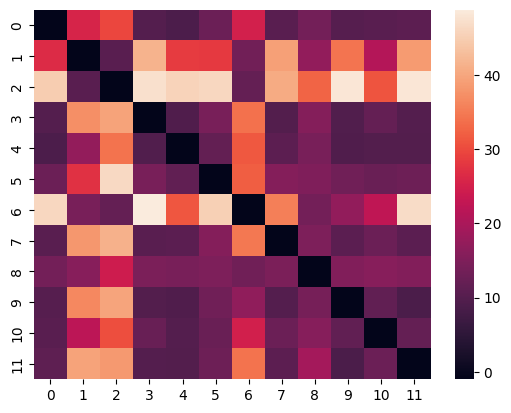

In [ ]:
dist_mat = pd.DataFrame()

for i in df['station'].unique():
  dist_station = []
  x = np.array(df[df['station'] == i]["PM2.5"])
  for j in df['station'].unique():
    if(i != j):
      y = np.array(df[df['station'] == j]["PM2.5"])
      dtw_distance, warp_path = fastdtw(x, y, dist=2)
      dist_station.append(dtw_distance/len(x))
    else:
      dist_station.append(-1)

  dist_mat[str(i)] = dist_station


sns.heatmap(dist_mat)

What this tells is that these stations are not the same. Not entirely surprising, but good to know. It means we need to account for them differently.

Now let's look at the monthly and daily rolling average to get a sense of what kinds of cyclical patterns might be in the data:

In [ ]:
df['daily_avg' ] = df['PM2.5'].rolling(24).mean()

<Axes: xlabel='timestamp'>

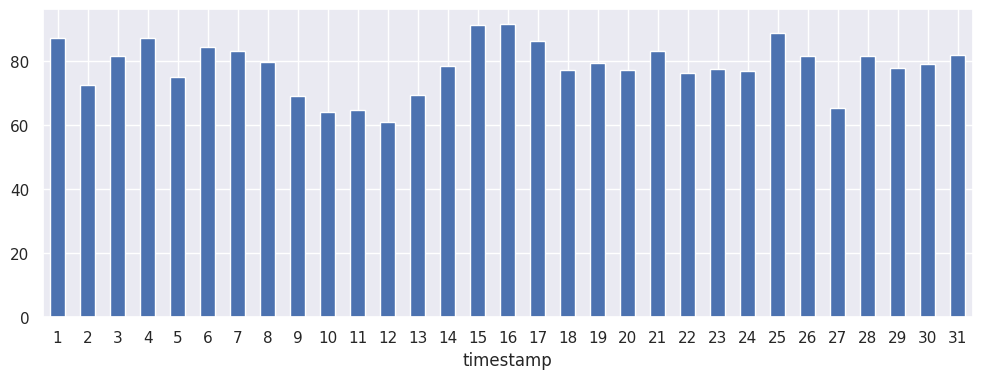

In [ ]:
fig, axs = plt.subplots(figsize=(12, 4))

df.groupby(df["timestamp"].dt.day)["PM2.5"].mean().plot(kind='bar', rot=0, ax=axs)

<Axes: xlabel='timestamp'>

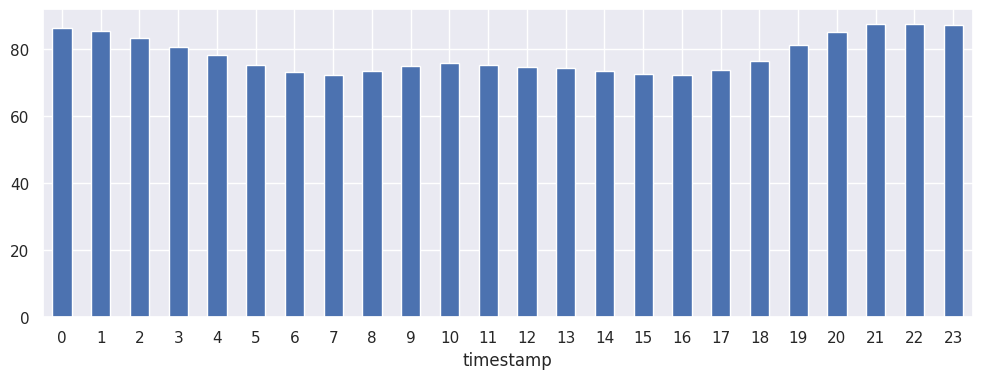

In [ ]:
fig, axs = plt.subplots(figsize=(12, 4))
df.groupby(df["timestamp"].dt.hour)["PM2.5"].mean().plot(kind='bar', rot=0, ax=axs)

<Axes: ylabel='PM2.5'>

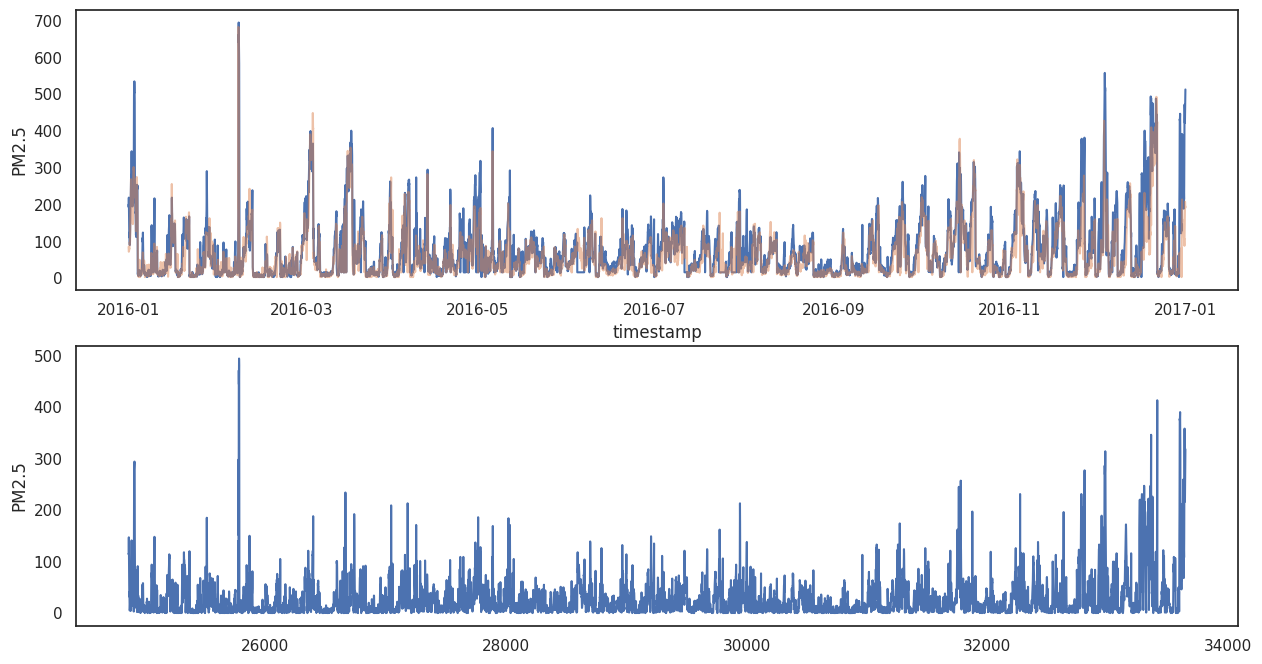

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

#daily_average = df[df['station'] == 1].groupby(df[df['station'] == 1]["timestamp"].dt.day)["PM2.5"].mean()

fig, axs = plt.subplots(2,1, figsize=(15, 8))
sns.lineplot(x = "timestamp", y = "PM2.5", data = df[(df['station'] == 3) & (df['year'] == 2016)], ax=axs[0])
sns.lineplot(x = "timestamp", y = "PM2.5", data = df[(df['station'] == 6) & (df['year'] == 2016)], ax=axs[0], alpha=0.5)

differencing = abs(df[(df['station'] == 3) & (df['year'] == 2016)]["PM2.5"] - df[(df['station'] == 6) & (df['year'] == 2016)]["PM2.5"])

sns.lineplot(data = differencing, ax=axs[1])

In [ ]:
np.mean(differencing)

28.802026411657558

In [ ]:
corr_mat = pd.DataFrame()
cov_mat = pd.DataFrame()

for i in df['station'].unique():
  corr_station = []
  cov_station = []
  for j in df['station'].unique():
    if(i != j):
      #corr_mat[i, j] = df[df["station"] == i]["PM2.5"].corr(df[df["station"] == j]["PM2.5"])
      #print(i, j, df[df["station"] == i]["PM2.5"].cov(df[df["station"] == j]["PM2.5"]))
      corr_station.append(df[df["station"] == i]["PM2.5"].corr(df[df["station"] == j]["PM2.5"]))
      cov_station.append(df[df["station"] == i]["PM2.5"].cov(df[df["station"] == j]["PM2.5"]))
    else:
      corr_station.append(-1)
      cov_station.append(-1)
  corr_mat[str(i)] = corr_station
  cov_mat[str(i)] = cov_station

<Axes: >

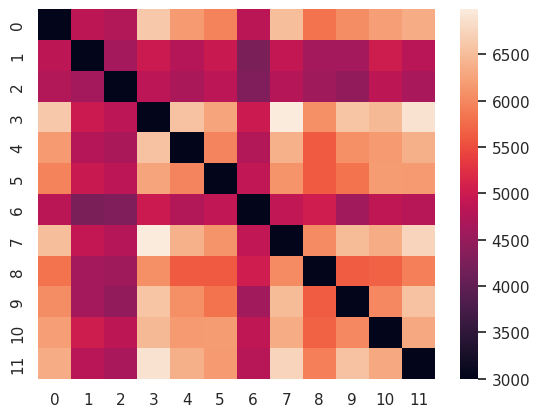

In [ ]:
sns.color_palette("flare")

sns.heatmap(cov_mat, vmin = 3000)

<Axes: >

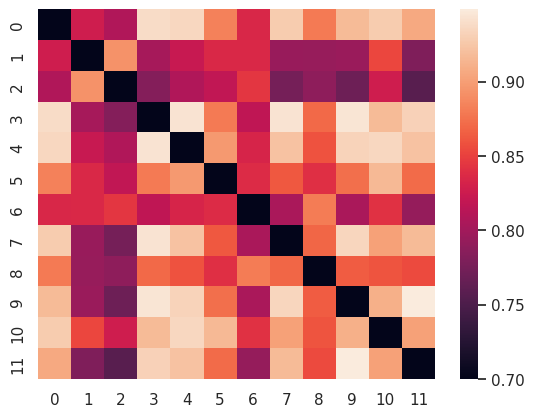

In [ ]:
sns.heatmap(corr_mat, vmin = 0.7)

Next, let's look at the ADF test. Interpreting the results, if we see a higher p-value that is an indication of non-stationarity.

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries, station_name):
  print("Results for station", station_name)
  result = adfuller(timeseries, autolag="AIC")
  print('test statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('observations used: %f' % result[3])
  print('Critical Values:')
  for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

for i in df['station'].unique():
  adf_test(df[(df['station'] == i)]['PM2.5'], str(i))


Results for station 0
test statistic: -19.096519
p-value: 0.000000
observations used: 35012.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Results for station 1
test statistic: -21.989901
p-value: 0.000000
observations used: 35038.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Results for station 2
test statistic: -19.501851
p-value: 0.000000
observations used: 35012.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Results for station 3
test statistic: -19.057672
p-value: 0.000000
observations used: 35012.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Results for station 4
test statistic: -19.560599
p-value: 0.000000
observations used: 35011.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Results for station 5
test statistic: -18.873612
p-value: 0.000000
observations used: 35012.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Results for station 6
test statistic: -19.563424
p-value: 0.000000
observations us

Looks like we don't have non-stationarity to worry about, our time serires don't possess strong trends.

Next, let's look at the KPSS test. Interpreting the results of its p-value is the opposite of the ADF test: a higher p-value is an indication of stationarity.

In [ ]:
from statsmodels.tsa.stattools import kpss


def kpss_test(timeseries, station):
    print("Results of KPSS Test for station ", station)
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)


for i in df['station'].unique():
  kpss_test(df[(df['station'] == i)]['PM2.5'], str(i))

Results of KPSS Test for station  0
Test Statistic             0.239015
p-value                    0.100000
Lags Used                106.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64
Results of KPSS Test for station  1
Test Statistic             0.544397
p-value                    0.031667
Lags Used                107.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64
Results of KPSS Test for station  2


<ipython-input-85-140993b5e628>:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")
<ipython-input-85-140993b5e628>:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")
<ipython-input-85-140993b5e628>:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")
<ipython-input-85-140993b5e628>:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest =

Test Statistic             0.276061
p-value                    0.100000
Lags Used                107.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64
Results of KPSS Test for station  3
Test Statistic             0.167471
p-value                    0.100000
Lags Used                106.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64
Results of KPSS Test for station  4
Test Statistic             0.147068
p-value                    0.100000
Lags Used                106.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64
Results of KPSS Test for station  5
Test Statistic             0.141487
p-value                    0.100000
Lags Used          

<ipython-input-85-140993b5e628>:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")
<ipython-input-85-140993b5e628>:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")
<ipython-input-85-140993b5e628>:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")
<ipython-input-85-140993b5e628>:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest =

Results of KPSS Test for station  6
Test Statistic             0.26127
p-value                    0.10000
Lags Used                107.00000
Critical Value (10%)       0.34700
Critical Value (5%)        0.46300
Critical Value (2.5%)      0.57400
Critical Value (1%)        0.73900
dtype: float64
Results of KPSS Test for station  7
Test Statistic             0.189226
p-value                    0.100000
Lags Used                106.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64
Results of KPSS Test for station  8
Test Statistic             0.139856
p-value                    0.100000
Lags Used                105.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64
Results of KPSS Test for station  9
Test Statistic             0.200034
p-value                   

<ipython-input-85-140993b5e628>:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


Once again, we seem to have stationarity in our series. So both of our tests have passed and we can move on to looking at some approaches to forecasting that we might be able to use.

Let's check seasonality:

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_analysis = df[(df["station"] == 0) & (df["year"] == 2014)][["PM2.5", "timestamp"]].copy()

tdi = pd.DatetimeIndex(seasonal_analysis["timestamp"])
seasonal_analysis.set_index(tdi, inplace=True)
seasonal_analysis.drop(columns='timestamp', inplace=True)
seasonal_analysis.index.name = 'datetimeindex'

In [62]:
decompose_result_mult = seasonal_decompose(seasonal_analysis, model="additive")

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

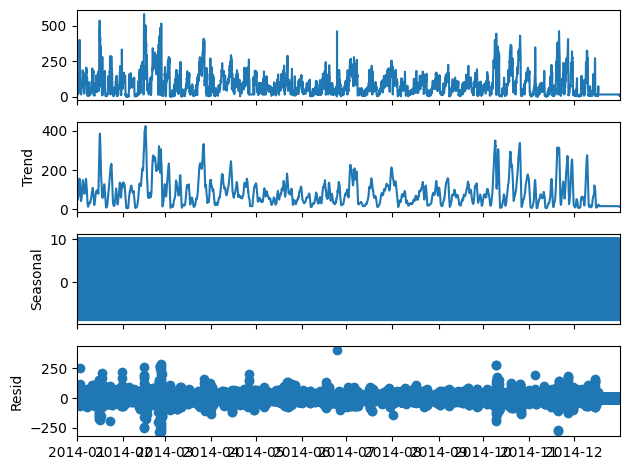

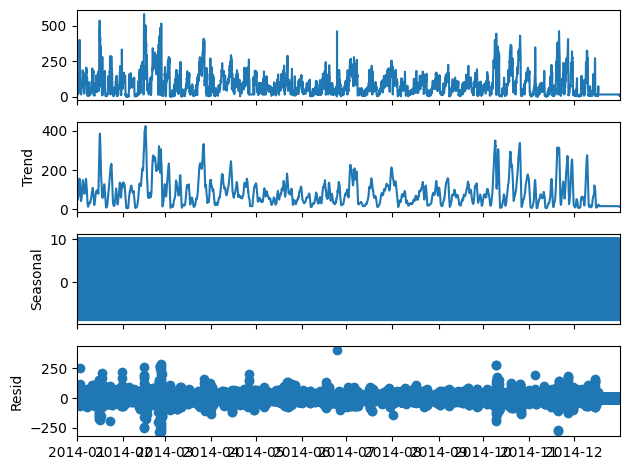

In [63]:
decompose_result_mult.plot()

In [64]:
print(seasonal.max())
print(seasonal.min())
print(seasonal.mean())

10.28236607142857
-8.78365956959707
7.218984415827502e-17
